In [ ]:
from glob import glob 


result_root_dir = "/workspace/data/results"

In [ ]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)
from scipy.stats import mode

def pkl_load(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

# 모든 모델 결과 로드
pkl_files = glob(f"{result_root_dir}/*.pkl")
results_dict = {}

for pkl_file in pkl_files:
    model_name = pkl_file.split('/')[-1].split('.')[0]
    pkl_dict = pkl_load(pkl_file)
    results_dict[model_name] = pkl_dict
    print(f"✓ {model_name} 로드 완료")

print(f"\n총 {len(results_dict)}개 모델 로드됨")


In [ ]:
# 결과 딕셔너리에서 각 모델별 주요 metric을 DataFrame으로 정리

metrics_list = []

for model_name, result in results_dict.items():
    test_labels = result['test_labels']
    test_preds = result['test_preds']
    test_proba = result['test_proba']
    
    # test_preds와 test_proba는 fold별 리스트 (보통 5개)
    if isinstance(test_preds, dict) and 'CatBoost' in test_preds:
        preds_list = test_preds['CatBoost']
    else:
        preds_list = test_preds
    
    if isinstance(test_proba, dict) and 'CatBoost' in test_proba:
        proba_list = test_proba['CatBoost']
    else:
        proba_list = test_proba

    accs, precs, recalls, f1s, aucs = [], [], [], [], []
    for fold_pred, fold_proba in zip(preds_list, proba_list):
        accs.append(accuracy_score(test_labels, fold_pred))
        precs.append(precision_score(test_labels, fold_pred))
        recalls.append(recall_score(test_labels, fold_pred))
        f1s.append(f1_score(test_labels, fold_pred))
        aucs.append(roc_auc_score(test_labels, fold_proba))

    metrics_list.append({
        "Model": model_name,
        "Accuracy_mean": np.mean(accs),
        "Accuracy_std": np.std(accs),
        "Precision_mean": np.mean(precs),
        "Precision_std": np.std(precs),
        "Recall_mean": np.mean(recalls),
        "Recall_std": np.std(recalls),
        "F1_mean": np.mean(f1s),
        "F1_std": np.std(f1s),
        "ROC AUC Score_mean": np.mean(aucs),
        "ROC AUC Score_std": np.std(aucs),
    })

df_metrics = pd.DataFrame(metrics_list)
df_metrics = df_metrics.set_index('Model')

df_metrics = df_metrics.sort_values(by="F1_mean", ascending=False)
df_metrics.round(3)


## 2. ROC 곡선 비교


In [ ]:
# Soft Voting (평균 확률)을 사용한 ROC 곡선 비교 + best threshold 위치 별로 표시
plt.figure(figsize=(12, 8))
colors = plt.cm.tab10(np.linspace(0, 1, len(results_dict)))

for idx, (model_name, result) in enumerate(results_dict.items()):
    test_labels = result['test_labels']
    test_proba = result['test_proba']
    
    # test_proba는 fold별로 저장되어 있음
    if isinstance(test_proba, dict) and 'CatBoost' in test_proba:
        proba_list = test_proba['CatBoost']
    elif isinstance(test_proba, list):
        proba_list = test_proba
    else:
        continue
    
    # Fold별 확률의 평균 계산 (Soft Voting)
    proba_array = np.array(proba_list)  # (n_folds, n_samples)
    avg_proba = np.mean(proba_array, axis=0)
    
    # ROC 곡선 및 best threshold 계산
    fpr, tpr, thresholds = roc_curve(test_labels, avg_proba)
    auc = roc_auc_score(test_labels, avg_proba)

    # best threshold: Youden's J statistic (tpr - fpr) 최대인 지점
    j_scores = tpr - fpr
    best_idx = np.argmax(j_scores)
    best_thr = thresholds[best_idx]
    best_fpr = fpr[best_idx]
    best_tpr = tpr[best_idx]
    
    # ROC Curve plot
    plt.plot(fpr, tpr, lw=2.5, label=f'{model_name} (AUC={auc:.3f})', 
             color=colors[idx], alpha=0.8)
    # best threshold에 ★ 표시
    plt.scatter(best_fpr, best_tpr, marker='*', s=200, color=colors[idx], edgecolors='black', zorder=10)

    # threshold 및 좌표 주석(optional)
    plt.annotate(f'{best_thr:.2f}', (best_fpr, best_tpr), 
                 textcoords="offset points", xytext=(10,-15), ha='center', color=colors[idx], fontsize=10)

# 대각선 (랜덤 분류기)
plt.plot([0, 1], [0, 1], '--', color='gray', lw=1.5, label='Random (AUC=0.500)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves Comparison (Soft Voting)', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
# Soft Voting (평균 확률)을 사용한 Precision-Recall 곡선 비교 + best threshold 위치 별로 표시
plt.figure(figsize=(12, 8))
colors = plt.cm.tab10(np.linspace(0, 1, len(results_dict)))

for idx, (model_name, result) in enumerate(results_dict.items()):
    test_labels = result['test_labels']
    test_proba = result['test_proba']
    
    # test_proba는 fold별로 저장되어 있음
    if isinstance(test_proba, dict) and 'CatBoost' in test_proba:
        proba_list = test_proba['CatBoost']
    elif isinstance(test_proba, list):
        proba_list = test_proba
    else:
        continue
    
    # Fold별 확률의 평균 계산 (Soft Voting)
    proba_array = np.array(proba_list)  # (n_folds, n_samples)
    avg_proba = np.mean(proba_array, axis=0)
    
    # Precision-Recall curve 및 best threshold 계산
    precision, recall, thresholds = precision_recall_curve(test_labels, avg_proba)
    # f1-score 최대가 되는 지점 = best threshold
    # thresholds: n-1개, precision/recall: n개 (맨 앞 1주의)
    f1_scores = 2 * precision[1:] * recall[1:] / (precision[1:] + recall[1:] + 1e-8)
    best_idx = np.argmax(f1_scores)
    best_thr = thresholds[best_idx]
    best_prec = precision[best_idx+1]
    best_rec = recall[best_idx+1]
    auprc = average_precision_score(test_labels, avg_proba)
    
    # Precision-Recall Curve plot
    plt.plot(recall, precision, lw=2.5, label=f'{model_name} (AUPRC={auprc:.3f})', 
             color=colors[idx], alpha=0.8)
    # best threshold에 ★ 표시
    plt.scatter(best_rec, best_prec, marker='*', s=200, color=colors[idx], edgecolors='black', zorder=10)
    # threshold 및 좌표 주석(optional)
    plt.annotate(f'{best_thr:.2f}', (best_rec, best_prec), 
                 textcoords="offset points", xytext=(10,-15), ha='center', color=colors[idx], fontsize=10)

# 랜덤 분류기의 베이스라인 (양성 비율)
pos_ratio = np.mean(np.concatenate([result['test_labels'] for result in results_dict.values()]))
plt.hlines(pos_ratio, 0, 1, colors='gray', linestyles='--', label=f'Random (Pos ratio={pos_ratio:.2f})', lw=1.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves Comparison (Soft Voting)', fontsize=14, fontweight='bold')
plt.legend(loc='lower left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Confusion Matrix 비교


In [ ]:
# 각 모델별 Confusion Matrix 시각화
n_models = len(results_dict)
cols = 2
rows = (n_models + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
if n_models == 1:
    axes = [axes]
else:
    axes = axes.flatten()

for idx, (model_name, result) in enumerate(results_dict.items()):
    test_labels = result['test_labels']
    test_preds = result['test_preds']
    
    # test_preds는 fold별로 저장되어 있음
    if isinstance(test_preds, dict) and 'CatBoost' in test_preds:
        preds_list = test_preds['CatBoost']
    elif isinstance(test_preds, list):
        preds_list = test_preds
    else:
        continue
    
    # Hard Voting (Majority Vote)
    preds_array = np.array(preds_list)  # (n_folds, n_samples)
    hard_voting_pred = mode(preds_array, axis=0, keepdims=False).mode
    
    # Confusion Matrix
    cm = confusion_matrix(test_labels, hard_voting_pred)
    
    # 시각화
    ax = axes[idx]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, 
                cbar_kws={'shrink': 0.8})
    ax.set_title(f'{model_name}\nAccuracy: {accuracy_score(test_labels, hard_voting_pred):.4f}', 
                 fontsize=11, fontweight='bold')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_xticklabels(['Class 0', 'Class 1'])
    ax.set_yticklabels(['Class 0', 'Class 1'])

# 사용하지 않는 subplot 제거
for idx in range(n_models, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


## 4. Feature Importance 비교


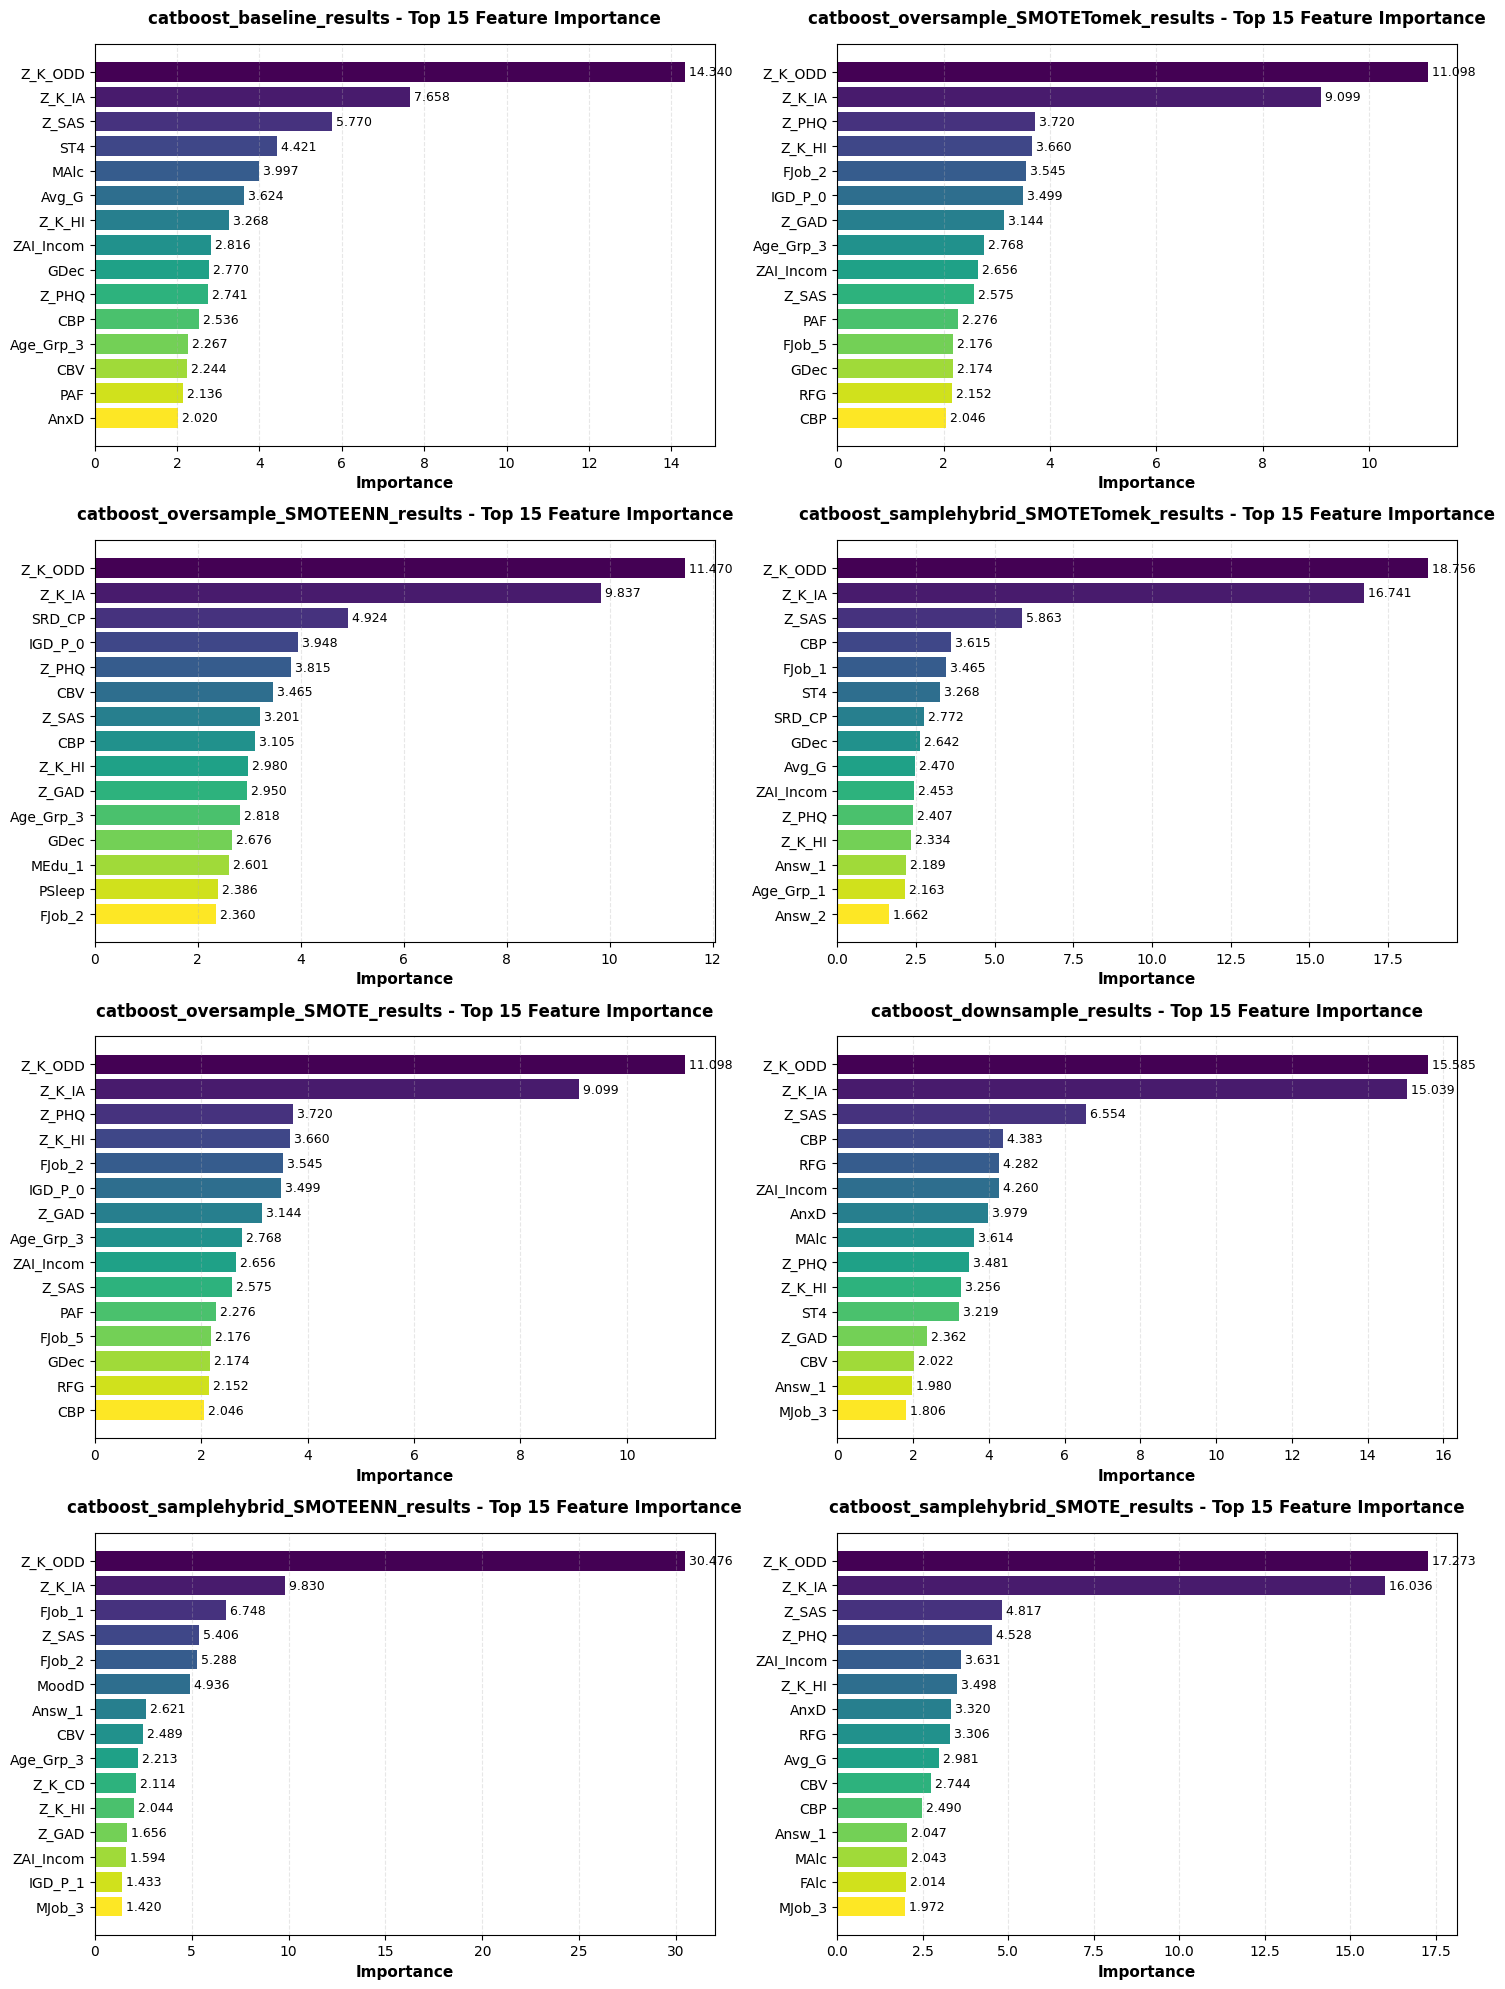


=== Feature Importance (Top 10) ===


[catboost_baseline_results]


,feature,importance
3,Z_K_ODD,14.339787
1,Z_K_IA,7.657595
29,Z_SAS,5.769617
28,ST4,4.420778
6,MAlc,3.997314
18,Avg_G,3.624387
2,Z_K_HI,3.267651
5,ZAI_Incom,2.816449
19,GDec,2.769990
12,Z_PHQ,2.740525



[catboost_oversample_SMOTETomek_results]


,feature,importance
3,Z_K_ODD,11.097894
1,Z_K_IA,9.099486
12,Z_PHQ,3.719832
2,Z_K_HI,3.660312
57,FJob_2,3.545315
63,IGD_P_0,3.499214
11,Z_GAD,3.143866
36,Age_Grp_3,2.768254
5,ZAI_Incom,2.655918
29,Z_SAS,2.574921



[catboost_oversample_SMOTEENN_results]


,feature,importance
3,Z_K_ODD,11.470111
1,Z_K_IA,9.836761
30,SRD_CP,4.923725
63,IGD_P_0,3.947527
12,Z_PHQ,3.815119
16,CBV,3.464737
29,Z_SAS,3.201219
17,CBP,3.104590
2,Z_K_HI,2.980362
11,Z_GAD,2.950425



[catboost_samplehybrid_SMOTETomek_results]


,feature,importance
3,Z_K_ODD,18.755717
1,Z_K_IA,16.740658
29,Z_SAS,5.863269
17,CBP,3.614860
56,FJob_1,3.464856
28,ST4,3.267752
30,SRD_CP,2.772266
19,GDec,2.642085
18,Avg_G,2.470182
5,ZAI_Incom,2.452647



[catboost_oversample_SMOTE_results]


,feature,importance
3,Z_K_ODD,11.097894
1,Z_K_IA,9.099486
12,Z_PHQ,3.719832
2,Z_K_HI,3.660312
57,FJob_2,3.545315
63,IGD_P_0,3.499214
11,Z_GAD,3.143866
36,Age_Grp_3,2.768254
5,ZAI_Incom,2.655918
29,Z_SAS,2.574921



[catboost_downsample_results]


,feature,importance
3,Z_K_ODD,15.585375
1,Z_K_IA,15.039288
29,Z_SAS,6.554248
17,CBP,4.382797
21,RFG,4.281591
5,ZAI_Incom,4.259994
24,AnxD,3.979471
6,MAlc,3.614285
12,Z_PHQ,3.480758
2,Z_K_HI,3.256472



[catboost_samplehybrid_SMOTEENN_results]


,feature,importance
3,Z_K_ODD,30.475933
1,Z_K_IA,9.830175
56,FJob_1,6.748427
29,Z_SAS,5.405820
57,FJob_2,5.288303
23,MoodD,4.935777
31,Answ_1,2.620795
16,CBV,2.489481
36,Age_Grp_3,2.213155
4,Z_K_CD,2.113765



[catboost_samplehybrid_SMOTE_results]


,feature,importance
3,Z_K_ODD,17.272811
1,Z_K_IA,16.035862
29,Z_SAS,4.816798
12,Z_PHQ,4.528403
5,ZAI_Incom,3.630544
2,Z_K_HI,3.497809
24,AnxD,3.319652
21,RFG,3.306299
18,Avg_G,2.981447
16,CBV,2.744287


In [24]:
# Feature Importance 시각화
n_models_with_fi = sum(1 for value in results_dict.values() if 'feature_importances' in value)

if n_models_with_fi > 0:
    # 모델별로 subplot 생성
    cols = 1 if n_models_with_fi == 1 else 2
    rows = (n_models_with_fi + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
    if n_models_with_fi == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if rows > 1 else [axes]
    
    plot_idx = 0
    for model_name, result in results_dict.items():
        if 'feature_importances' not in result:
            continue
            
        feature_importance_df = result['feature_importances']
        
        # 상위 15개 feature 선택
        top_features = feature_importance_df.head(15)
        
        # 막대 그래프 생성
        ax = axes[plot_idx]
        colors = plt.cm.viridis(np.linspace(0, 1, len(top_features)))
        bars = ax.barh(range(len(top_features)), top_features['importance'].values, color=colors)
        
        # Y축에 feature 이름 표시
        ax.set_yticks(range(len(top_features)))
        ax.set_yticklabels(top_features['feature'].values, fontsize=10)
        ax.invert_yaxis()  # 중요도 높은 순서대로 위에 표시
        
        # X축 레이블
        ax.set_xlabel('Importance', fontsize=11, fontweight='bold')
        ax.set_title(f'{model_name} - Top 15 Feature Importance', 
                     fontsize=12, fontweight='bold', pad=15)
        
        # 그리드 추가
        ax.grid(axis='x', alpha=0.3, linestyle='--')
        
        # 각 막대에 값 표시 (선택사항)
        for i, (idx, row) in enumerate(top_features.iterrows()):
            ax.text(row['importance'], i, f' {row["importance"]:.3f}', 
                   va='center', fontsize=9)
        
        plot_idx += 1
    
    # 사용하지 않는 subplot 제거
    for idx in range(plot_idx, len(axes)):
        fig.delaxes(axes[idx])
    
    plt.tight_layout()
    plt.show()
    
    # 테이블로도 출력
    print("\n=== Feature Importance (Top 10) ===\n")
    for model_name, result in results_dict.items():
        if 'feature_importances' in result:
            print(f"\n[{model_name}]")
            display(result['feature_importances'].head(10))
else:
    print("Feature importance 데이터가 없습니다.")

# 5. Shap Value 비교

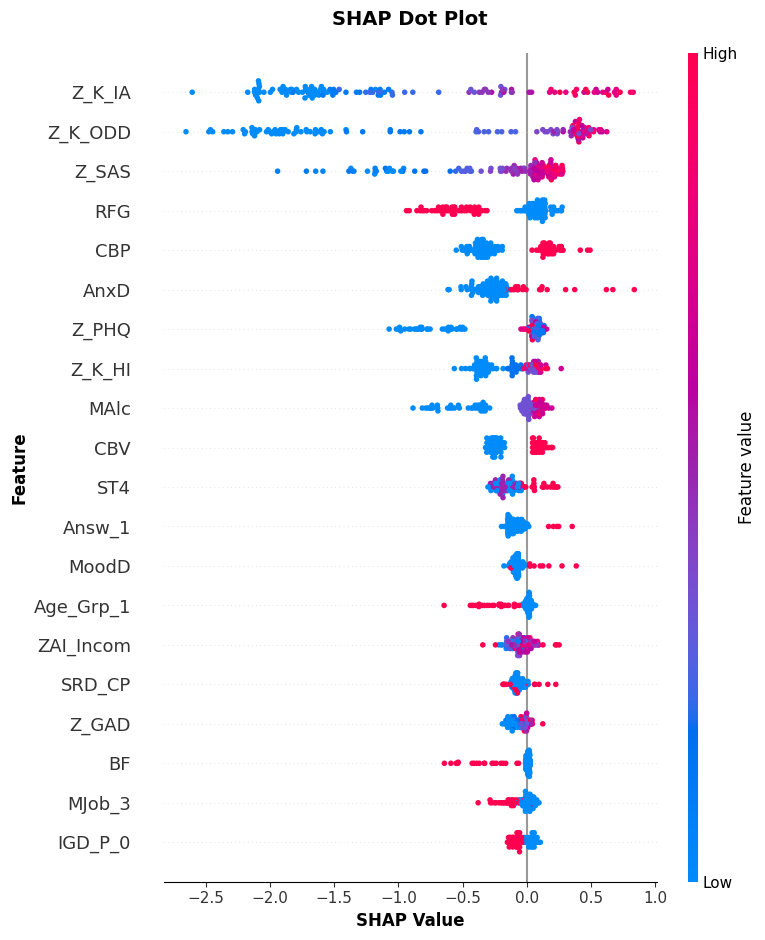

In [25]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# SHAP values 불러오기
shap_values_list = results_dict['catboost_downsample_results']['shap_values_test']['CatBoost']
test_inputs = results_dict['catboost_downsample_results']['test_inputs']

# SHAP values는 fold별로 리스트로 저장되어 있으므로 평균 계산
# 각 fold의 SHAP values를 numpy array로 변환 후 평균
shap_values_array = np.array(shap_values_list)  # (n_folds, n_samples, n_features)
shap_values_mean = np.mean(shap_values_array, axis=0)  # (n_samples, n_features)

# 한글 폰트 설정 (리눅스 기준으로 수정, 필요시 변경)
try:
    plt.rc('font', family='DejaVu Sans')
except:
    pass

# SHAP dot plot 생성
plt.figure(figsize=(10, 6))

# summary_plot로 dot plot 생성
shap.summary_plot(
    shap_values_mean, 
    test_inputs, 
    plot_type="dot",         # dot plot
    show=False,              # show=False로 설정하여 직접 제어
    color_bar=True,
    # max_display=15           # 상위 15개 feature 표시
)

plt.xlabel("SHAP Value", fontsize=12, fontweight='bold')
plt.ylabel("Feature", fontsize=12, fontweight='bold')
plt.title("SHAP Dot Plot", fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

## Covariance Matrix 비교

상위 20개 feature의 Covariance Matrix를 시각화합니다.


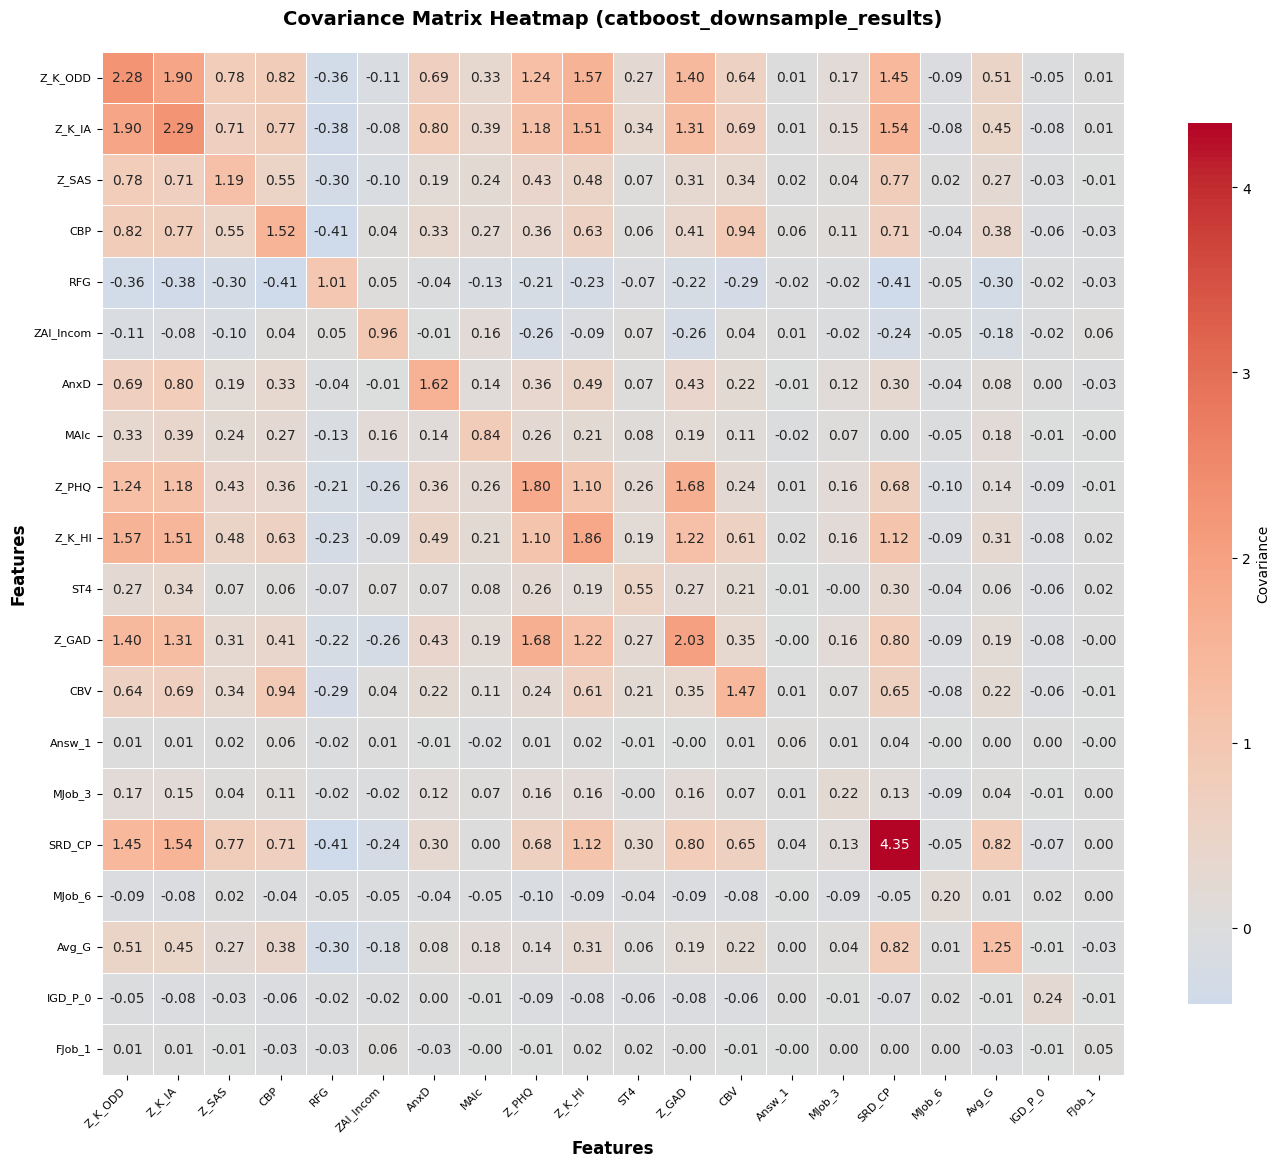


Covariance Matrix 통계:
  Shape: (20, 20)
  Min: -0.4097
  Max: 4.3470
  Mean: 0.2598
  Std: 0.2837


In [27]:
# Covariance Matrix 시각화
result = results_dict['catboost_downsample_results']
test_inputs = result['test_inputs']

# Covariance Matrix 계산
cov_matrix = test_inputs.cov()

# Feature가 많을 경우 상위 중요 feature만 선택 (선택사항)
# feature_importance를 사용하여 상위 N개 feature 선택
if 'feature_importances' in result:
    top_features = result['feature_importances'].head(20)['feature'].tolist()
    # test_inputs에 있는 feature만 필터링
    top_features = [f for f in top_features if f in test_inputs.columns]
    if len(top_features) > 0:
        cov_matrix = test_inputs[top_features].cov()
        print(f"상위 {len(top_features)}개 feature의 Covariance Matrix를 시각화합니다.")
    else:
        print("Feature importance와 test_inputs의 feature가 일치하지 않습니다. 전체 feature를 사용합니다.")
else:
    # Feature가 너무 많으면 일부만 선택 (예: 상위 30개)
    if len(test_inputs.columns) > 30:
        # 분산이 큰 feature 상위 30개 선택
        feature_vars = test_inputs.var().sort_values(ascending=False)
        top_features = feature_vars.head(30).index.tolist()
        cov_matrix = test_inputs[top_features].cov()
        print(f"Feature가 많아 분산 상위 {len(top_features)}개 feature의 Covariance Matrix를 시각화합니다.")
    else:
        print(f"전체 {len(test_inputs.columns)}개 feature의 Covariance Matrix를 시각화합니다.")

# Heatmap 시각화
plt.figure(figsize=(14, 12))
sns.heatmap(
    cov_matrix,
    annot=True,  # 값이 많으면 False로 설정
    fmt='.2f',
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8, "label": "Covariance"},
    xticklabels=True,
    yticklabels=True
)

plt.title('Covariance Matrix Heatmap (catboost_downsample_results)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Features', fontsize=12, fontweight='bold')
plt.ylabel('Features', fontsize=12, fontweight='bold')

# X축, Y축 레이블 회전 (가독성 향상)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)

plt.tight_layout()
plt.show()

# 통계 정보 출력
print(f"\nCovariance Matrix 통계:")
print(f"  Shape: {cov_matrix.shape}")
print(f"  Min: {cov_matrix.min().min():.4f}")
print(f"  Max: {cov_matrix.max().max():.4f}")
print(f"  Mean: {cov_matrix.mean().mean():.4f}")
print(f"  Std: {cov_matrix.std().std():.4f}")

COVARIANCE MATRIX 분석 결과

1. 높은 양의 공분산을 가진 Feature 쌍 (다중공선성 가능성)
----------------------------------------------------------------------


,Feature1,Feature2,Covariance
0,Z_K_ODD,Z_K_IA,1.900105
10,Z_PHQ,Z_GAD,1.684714
2,Z_K_ODD,Z_K_HI,1.568261
8,Z_K_IA,SRD_CP,1.536341
6,Z_K_IA,Z_K_HI,1.510545
4,Z_K_ODD,SRD_CP,1.453356
3,Z_K_ODD,Z_GAD,1.403230
7,Z_K_IA,Z_GAD,1.311618
1,Z_K_ODD,Z_PHQ,1.235595
11,Z_K_HI,Z_GAD,1.215357



총 13개의 높은 공분산 쌍 발견 (임계값: >1.0)

2. 높은 음의 공분산을 가진 Feature 쌍 (반대 관계)
----------------------------------------------------------------------


,Feature1,Feature2,Covariance
3,CBP,RFG,-0.409739
4,RFG,SRD_CP,-0.408937
1,Z_K_IA,RFG,-0.379008
0,Z_K_ODD,RFG,-0.356978
5,RFG,Avg_G,-0.303765
2,Z_SAS,RFG,-0.303059



총 6개의 높은 음의 공분산 쌍 발견 (임계값: <-0.3)

3. 독립적인 Feature (다른 Feature들과 낮은 공분산)
----------------------------------------------------------------------
평균 절대 공분산이 낮은 Feature (독립적):


,Feature,Avg_Abs_Covariance,Max_Abs_Covariance
19,FJob_1,0.014063,0.059622
13,Answ_1,0.014081,0.064019
18,IGD_P_0,0.039933,0.085419
16,MJob_6,0.053038,0.104583
14,MJob_3,0.080464,0.165708
5,ZAI_Incom,0.096785,0.259013
10,ST4,0.128336,0.344701
7,MAlc,0.150144,0.392784
4,RFG,0.186433,0.409739
17,Avg_G,0.220089,0.816162



4. Feature 그룹화 분석 (높은 공분산을 가진 Feature 그룹)
----------------------------------------------------------------------
Feature 클러스터 그룹:

  클러스터 1 (6개):
    Z_K_ODD, Z_K_IA, Z_K_HI, Z_PHQ, SRD_CP, Z_GAD

  클러스터 2 (5개):
    Z_SAS, CBP, CBV, RFG, Avg_G

  클러스터 3 (9개):
    ZAI_Incom, MAlc, ST4, Answ_1, AnxD, MJob_3, MJob_6, IGD_P_0, FJob_1


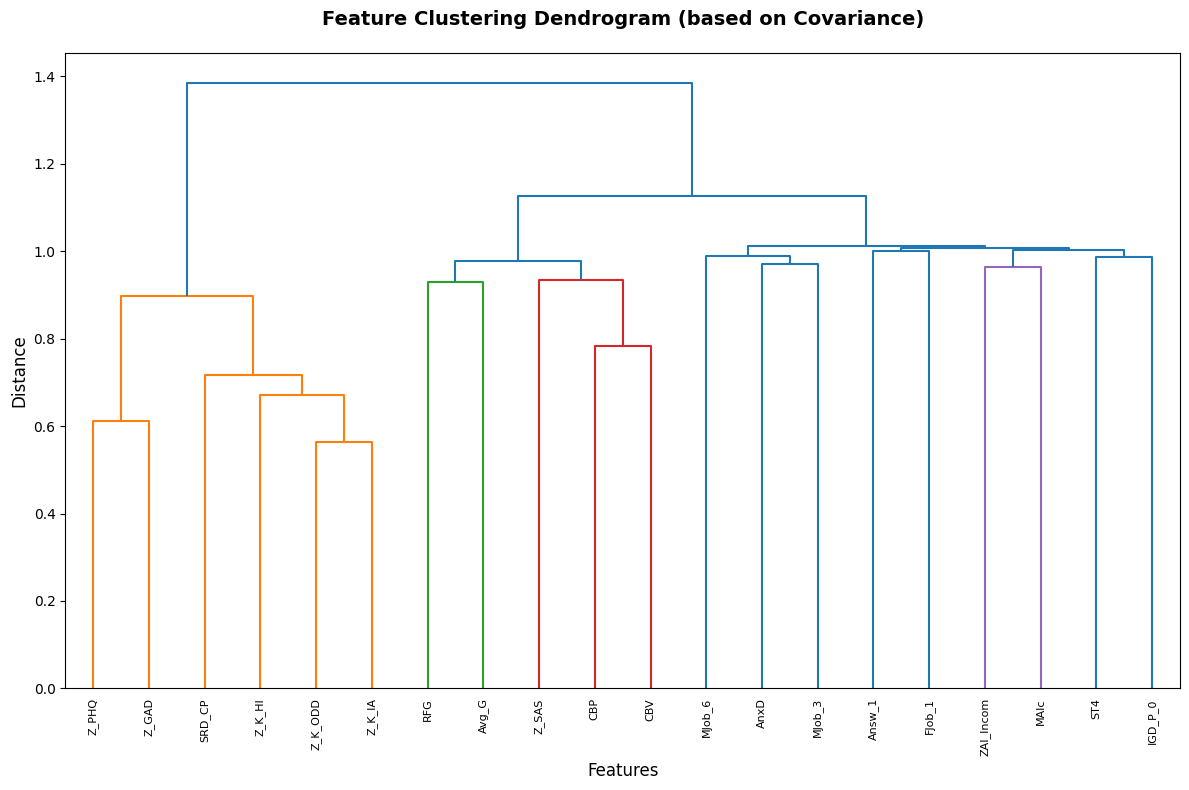


5. Feature별 총 공분산 합 (다른 Feature들과의 전체 연관성)
----------------------------------------------------------------------


,Feature,Total_Covariance,Abs_Total_Covariance
0,Z_K_ODD,11.192042,12.387137
1,Z_K_IA,11.138391,12.375965
9,Z_K_HI,9.137598,10.103081
15,SRD_CP,8.532365,10.068983
11,Z_GAD,8.065133,9.370317
8,Z_PHQ,7.421506,8.766823
3,CBP,5.894970,6.981191
12,CBV,4.887233,5.773123
2,Z_SAS,4.793700,5.667012
6,AnxD,4.098527,4.349140



분석 요약:
• 높은 양의 공분산 쌍: 13개 → 다중공선성 주의 필요
• 높은 음의 공분산 쌍: 6개 → 반대 관계 Feature
• 독립적인 Feature: 6개 → 다른 Feature와 낮은 연관성
• 가장 연관성 높은 Feature: Z_K_ODD (총 절대 공분산: 12.39)
• 가장 독립적인 Feature: FJob_1 (평균 절대 공분산: 0.0141)


In [28]:
# Covariance Matrix 분석

result = results_dict['catboost_downsample_results']
test_inputs = result['test_inputs']

# Feature 선택 (이전 셀과 동일한 로직)
if 'feature_importances' in result:
    top_features = result['feature_importances'].head(20)['feature'].tolist()
    top_features = [f for f in top_features if f in test_inputs.columns]
    if len(top_features) > 0:
        selected_features = top_features
    else:
        selected_features = test_inputs.columns.tolist()
else:
    if len(test_inputs.columns) > 30:
        feature_vars = test_inputs.var().sort_values(ascending=False)
        selected_features = feature_vars.head(30).index.tolist()
    else:
        selected_features = test_inputs.columns.tolist()

cov_matrix = test_inputs[selected_features].cov()

print("="*70)
print("COVARIANCE MATRIX 분석 결과")
print("="*70)

# 1. 높은 양의 공분산을 가진 Feature 쌍 찾기 (다중공선성 확인)
print("\n1. 높은 양의 공분산을 가진 Feature 쌍 (다중공선성 가능성)")
print("-"*70)
high_cov_pairs = []
for i in range(len(cov_matrix.columns)):
    for j in range(i+1, len(cov_matrix.columns)):
        cov_value = cov_matrix.iloc[i, j]
        if cov_value > 1.0:  # 임계값 조정 가능
            high_cov_pairs.append({
                'Feature1': cov_matrix.columns[i],
                'Feature2': cov_matrix.columns[j],
                'Covariance': cov_value
            })

if high_cov_pairs:
    high_cov_df = pd.DataFrame(high_cov_pairs).sort_values('Covariance', ascending=False)
    display(high_cov_df.head(10))
    print(f"\n총 {len(high_cov_pairs)}개의 높은 공분산 쌍 발견 (임계값: >1.0)")
else:
    print("높은 양의 공분산을 가진 쌍이 없습니다.")

# 2. 높은 음의 공분산을 가진 Feature 쌍 찾기
print("\n2. 높은 음의 공분산을 가진 Feature 쌍 (반대 관계)")
print("-"*70)
negative_cov_pairs = []
for i in range(len(cov_matrix.columns)):
    for j in range(i+1, len(cov_matrix.columns)):
        cov_value = cov_matrix.iloc[i, j]
        if cov_value < -0.3:  # 임계값 조정 가능
            negative_cov_pairs.append({
                'Feature1': cov_matrix.columns[i],
                'Feature2': cov_matrix.columns[j],
                'Covariance': cov_value
            })

if negative_cov_pairs:
    negative_cov_df = pd.DataFrame(negative_cov_pairs).sort_values('Covariance', ascending=True)
    display(negative_cov_df.head(10))
    print(f"\n총 {len(negative_cov_pairs)}개의 높은 음의 공분산 쌍 발견 (임계값: <-0.3)")
else:
    print("높은 음의 공분산을 가진 쌍이 없습니다.")

# 3. 독립적인 Feature 찾기 (공분산이 0에 가까운 Feature)
print("\n3. 독립적인 Feature (다른 Feature들과 낮은 공분산)")
print("-"*70)
feature_independence = []
for feature in cov_matrix.columns:
    # 자기 자신과의 공분산(분산) 제외
    other_covs = cov_matrix[feature].drop(feature)
    avg_abs_cov = other_covs.abs().mean()
    max_abs_cov = other_covs.abs().max()
    feature_independence.append({
        'Feature': feature,
        'Avg_Abs_Covariance': avg_abs_cov,
        'Max_Abs_Covariance': max_abs_cov
    })

independence_df = pd.DataFrame(feature_independence).sort_values('Avg_Abs_Covariance', ascending=True)
print("평균 절대 공분산이 낮은 Feature (독립적):")
display(independence_df.head(10))

# 4. Feature 그룹화 (클러스터링)
print("\n4. Feature 그룹화 분석 (높은 공분산을 가진 Feature 그룹)")
print("-"*70)
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

# 공분산 행렬을 거리 행렬로 변환 (1 - 정규화된 공분산)
# 높은 공분산 = 낮은 거리
cov_abs = cov_matrix.abs()
cov_max = cov_abs.max().max()
if cov_max > 0:
    # 정규화: 0~1 범위로 변환
    cov_normalized = cov_abs / cov_max
    # 거리로 변환: 1 - 정규화된 공분산
    distance_matrix = 1 - cov_normalized
    # 대각선을 0으로 설정
    np.fill_diagonal(distance_matrix.values, 0)
    
    # 계층적 클러스터링
    condensed_distances = squareform(distance_matrix.values)
    linkage_matrix = linkage(condensed_distances, method='ward')
    
    # 클러스터 할당 (3개 그룹)
    clusters = fcluster(linkage_matrix, t=3, criterion='maxclust')
    cluster_df = pd.DataFrame({
        'Feature': cov_matrix.columns,
        'Cluster': clusters
    }).sort_values('Cluster')
    
    print("Feature 클러스터 그룹:")
    for cluster_id in sorted(cluster_df['Cluster'].unique()):
        cluster_features = cluster_df[cluster_df['Cluster'] == cluster_id]['Feature'].tolist()
        print(f"\n  클러스터 {cluster_id} ({len(cluster_features)}개):")
        print(f"    {', '.join(cluster_features)}")
    
    # Dendrogram 시각화
    plt.figure(figsize=(12, 8))
    dendrogram(linkage_matrix, labels=cov_matrix.columns.tolist(), 
               leaf_rotation=90, leaf_font_size=8)
    plt.title('Feature Clustering Dendrogram (based on Covariance)', 
              fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Distance', fontsize=12)
    plt.tight_layout()
    plt.show()

# 5. 각 Feature의 총 공분산 합 (다른 Feature들과의 전체적인 연관성)
print("\n5. Feature별 총 공분산 합 (다른 Feature들과의 전체 연관성)")
print("-"*70)
feature_total_cov = []
for feature in cov_matrix.columns:
    # 자기 자신과의 공분산(분산) 제외
    total_cov = cov_matrix[feature].drop(feature).sum()
    abs_total_cov = cov_matrix[feature].drop(feature).abs().sum()
    feature_total_cov.append({
        'Feature': feature,
        'Total_Covariance': total_cov,
        'Abs_Total_Covariance': abs_total_cov
    })

total_cov_df = pd.DataFrame(feature_total_cov).sort_values('Abs_Total_Covariance', ascending=False)
display(total_cov_df)

print("\n" + "="*70)
print("분석 요약:")
print("="*70)
print(f"• 높은 양의 공분산 쌍: {len(high_cov_pairs)}개 → 다중공선성 주의 필요")
print(f"• 높은 음의 공분산 쌍: {len(negative_cov_pairs)}개 → 반대 관계 Feature")
print(f"• 독립적인 Feature: {len(independence_df[independence_df['Avg_Abs_Covariance'] < 0.1])}개 → 다른 Feature와 낮은 연관성")
print(f"• 가장 연관성 높은 Feature: {total_cov_df.iloc[0]['Feature']} (총 절대 공분산: {total_cov_df.iloc[0]['Abs_Total_Covariance']:.2f})")
print(f"• 가장 독립적인 Feature: {independence_df.iloc[0]['Feature']} (평균 절대 공분산: {independence_df.iloc[0]['Avg_Abs_Covariance']:.4f})")
